# AutoAnnotation-for-ObjectDetection

---


## Overview
本ノートブックは[GroundingDINO](https://github.com/IDEA-Research/GroundingDINO)を使用して、与えたプロンプトに関するオブジェクトを検出し、自動でアノテーションを行うプログラムです。<br>

## Setup

In [1]:
!nvidia-smi

Mon Oct  9 10:27:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Grounding DINO 🦕

In [2]:
%cd ..
!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/app/auto_annotation
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 401 (delta 52), reused 44 (delta 44), pack-reused 324
Receiving objects: 100% (401/401), 12.84 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (205/205), done.
/app/auto_annotation/GroundingDINO


In [3]:
import os
import cv2
import supervision as sv
import locale
from tqdm import tqdm
from groundingdino.util.inference import load_model, load_image, predict, annotate

In [7]:
# 後述のモデル読み込み時のエラー対策で、絶対パスを指定しています
CONFIG_PATH = "/app/auto_annotation/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/app/auto_annotation/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


## Download Grounding DINO Weights 🏋️

In [8]:
!mkdir weights
%cd weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/app/auto_annotation/GroundingDINO/weights


In [9]:
# WEIGHTS_PATH = "groundingdino_swint_ogc.pt"
WEIGHTS_PATH = "/app/auto_annotation/GroundingDINO/weights/groundingdino_swint_ogc.pth"
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/app/auto_annotation/GroundingDINO/weights/groundingdino_swint_ogc.pth ; exist: True


## Load Grounding DINO Model

In [10]:
%cd ../

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/app/auto_annotation/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## Usage
以下のセルを順に実行してください。<br>
実行前のパラメータ設定については、目的や検出したいオブジェクトに応じて適宜変更してください。<br>
実行結果は、Image-Processing-Utils/auto_annotation/{output_dir}配下に保存されます。以下のサブディレクトリ構成で保存されます。<br>


ディレクトリ構成
*   annotated_images

  *   GroundingDINOによりアノテーションされた画像（.jpg）
*   labels
  *   YOLO形式のアノテーションラベル（.txt）
*   original_images
  *   アノテーション前の元画像（.jpg）




### YOLO形式アノテーションラベル

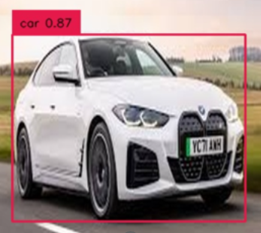

アノテーションラベルの例<br>
```
0 0.4902520179748535 0.5475240349769592 0.7336750030517578 0.5903536677360535
```
1列目: 物体のクラスID<br>
2列目: BBoxの中心のx座標（x_center）<br>
3列目: BBoxの中心のy座標（y_center）<br>
4列目: BBoxの幅（width）<br>
5列目: BBoxの高さ（height）<br>




In [11]:
import os
import shutil
from tqdm.notebook import tqdm

def save_annotated_image(annotated_image, output_dir, image_name):
    """アノテーションされた画像を指定したディレクトリに保存する

    Args:
        annotated_image (numpy.ndarray): 保存する画像データ
        output_dir (str): 画像の保存先のパス
        image_name (str): 画像のファイル名
    """
    annotated_image_name = f"annotated_{image_name}"

    try:
        annotated_output_dir = os.path.join(output_dir, "annotated_images")
        os.makedirs(annotated_output_dir, exist_ok=True)

        output_path = os.path.join(annotated_output_dir, annotated_image_name)
        cv2.imwrite(output_path, annotated_image)
        print(f"{annotated_image_name} が保存されました。")
    except Exception as e:
        print(f"{annotated_image_name}の保存に失敗しました。エラーメッセージ: {str(e)}")


def save_yolo_format_label(boxes, output_dir, image_name):
    """bboxの情報をYOLOフォーマットの.txtファイルとして保存する

    Args:
        boxes (List[Tuple[float, float, float, float]]): 各bboxの情報を含むリスト
          - 各bboxは(x_center, y_center, width, height)の形式で表される
        output_dir (str): テキストファイルの保存先のディレクトリパス
        image_name (str): 画像のファイル名（拡張子を除く）
    """
    label_name = os.path.splitext(image_name)[0] + '.txt'

    try:
        label_output_dir = os.path.join(output_dir, "labels")
        os.makedirs(label_output_dir, exist_ok=True)
        label_output_path = os.path.join(label_output_dir, label_name)

        with open(label_output_path, 'w') as file:
            for box in boxes:
                line = f"0 {box[0]} {box[1]} {box[2]} {box[3]}\n"
                file.write(line)

        print(f"{label_name} が保存されました。")
    except Exception as e:
        print(f"{label_name}の保存に失敗しました。エラーメッセージ: {str(e)}")


def annotate_and_save_image(input_dir, output_dir, text_prompt, box_threshold, text_threshold):
    """GroundingDINOを使用して、与えたプロンプトに関するオブジェクトを検出し、画像をアノテーションして保存する

    Args:
        input_dir (str): 入力画像のディレクトリパス
        output_dir (str): 画像の保存先のディレクトリパス
        text_prompt (str): テキストのプロンプト
        box_threshold (float): ボックスの閾値
        text_threshold (float): テキストの閾値
    """
    image_source, image = load_image(input_dir)

    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    annotated_image = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

    image_name = os.path.basename(input_dir)
    save_annotated_image(annotated_image, output_dir, image_name)
    save_yolo_format_label(boxes, output_dir, image_name)

    # 元の画像を output_dir/original_images に移動
    raw_output_dir = os.path.join(output_dir, "original_images")
    os.makedirs(raw_output_dir, exist_ok=True)
    shutil.move(input_dir, os.path.join(raw_output_dir, image_name))

In [12]:
# ------------------------------
# 実行前のパラメータ設定
# ------------------------------
input_dir = "../../image_scraping/save_images/car"
output_dir = "../annotation_results"
text_prompt = "car"
box_threshold = 0.3
text_threshold = 0.3

In [14]:
# # ------------------------------
# # 実行前のパラメータ設定 ※Demo用（後述のResult Variations参照）
# # ------------------------------
# input_dir = "../../assets/img"
# output_dir = "../demo_annotation_results"
# text_prompt = "car,bicycle"
# box_threshold = 0.3
# text_threshold = 0.3

In [13]:
image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

for image_file in tqdm(image_files):
    image_path = os.path.join(input_dir, image_file)
    annotate_and_save_image(image_path, output_dir, text_prompt, box_threshold, text_threshold)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


annotated_car_20231009_192543_87.jpg が保存されました。
car_20231009_192543_87.txt が保存されました。
annotated_car_20231009_192538_71.jpg が保存されました。
car_20231009_192538_71.txt が保存されました。
annotated_car_20231009_192529_33.jpg が保存されました。
car_20231009_192529_33.txt が保存されました。
annotated_car_20231009_192528_29.jpg が保存されました。
car_20231009_192528_29.txt が保存されました。
annotated_car_20231009_192532_45.jpg が保存されました。
car_20231009_192532_45.txt が保存されました。
annotated_car_20231009_192523_15.jpg が保存されました。
car_20231009_192523_15.txt が保存されました。
annotated_car_20231009_192545_95.jpg が保存されました。
car_20231009_192545_95.txt が保存されました。
annotated_car_20231009_192530_37.jpg が保存されました。
car_20231009_192530_37.txt が保存されました。
annotated_car_20231009_192520_4.jpg が保存されました。
car_20231009_192520_4.txt が保存されました。
annotated_car_20231009_192526_26.jpg が保存されました。
car_20231009_192526_26.txt が保存されました。
annotated_car_20231009_192529_35.jpg が保存されました。
car_20231009_192529_35.txt が保存されました。
annotated_car_20231009_192538_69.jpg が保存されました。
car_20231009_192538_69.txt が保存さ

## Result Variations
以下のサンプル画像に対して、GroundingDINOを使用した検出結果は以下のようになりました。<br>


### 元画像

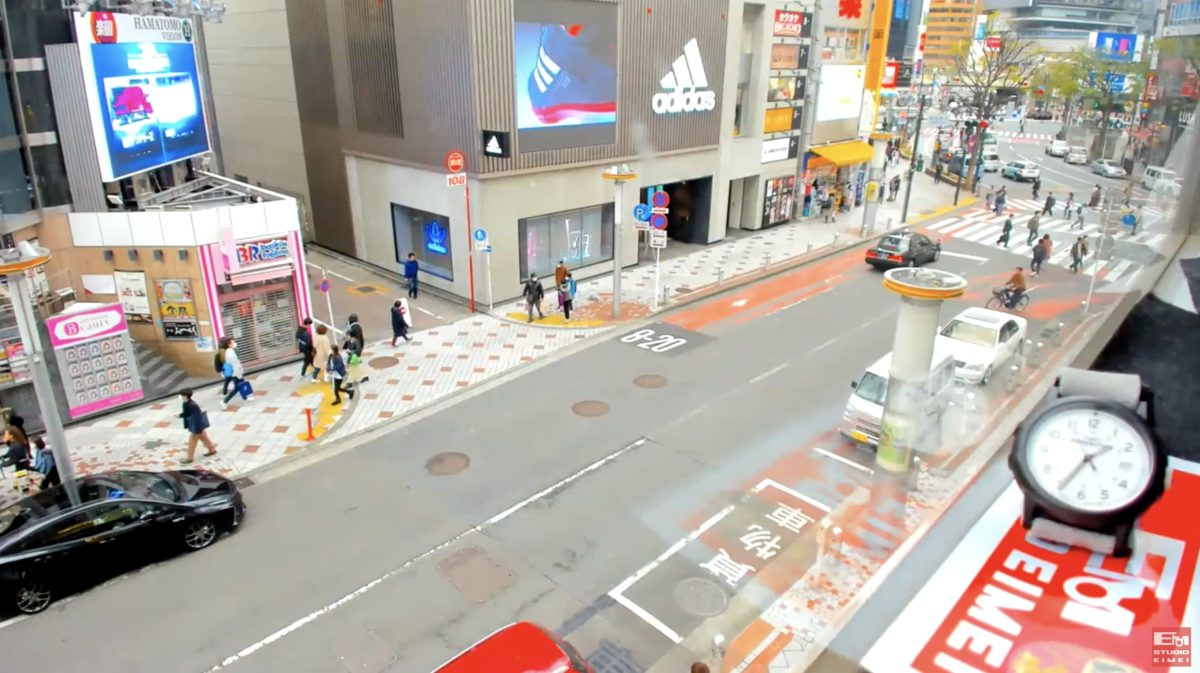

### **1. Car**
パラメータ設定
*   text_prompt="car"

*   box_threshold = 0.3
*   text_threshold = 0.3



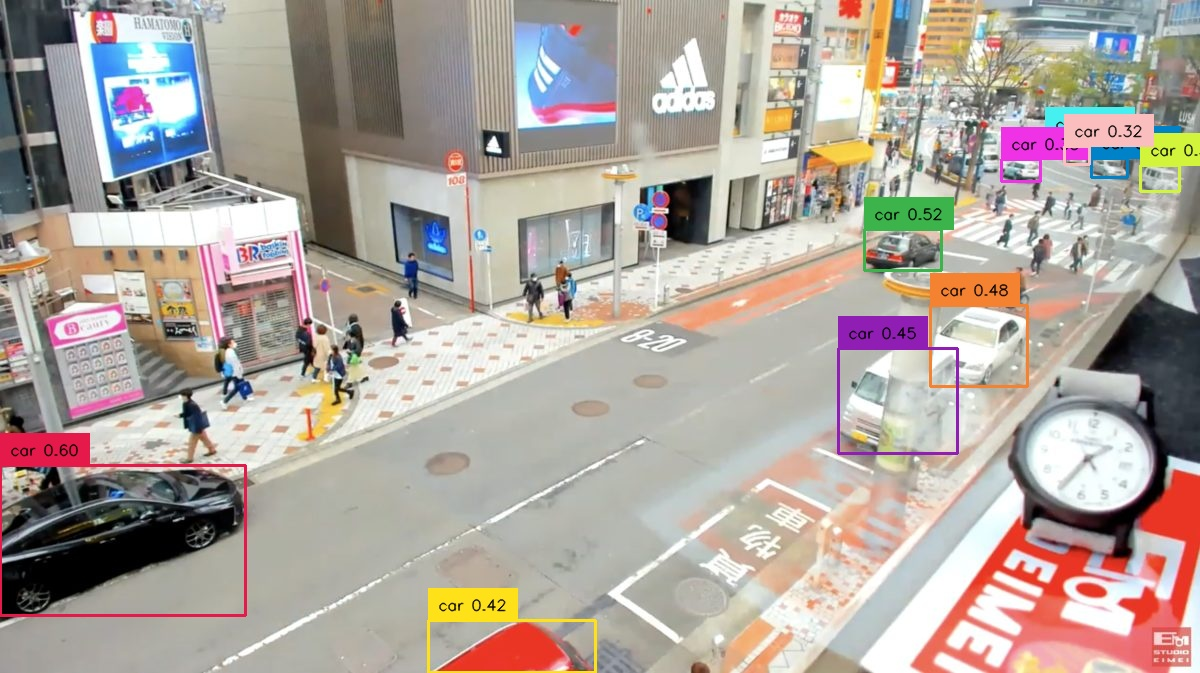

### **2. Bicycle**
パラメータ設定
*   text_prompt="bicycle"

*   box_threshold = 0.3
*   text_threshold = 0.3

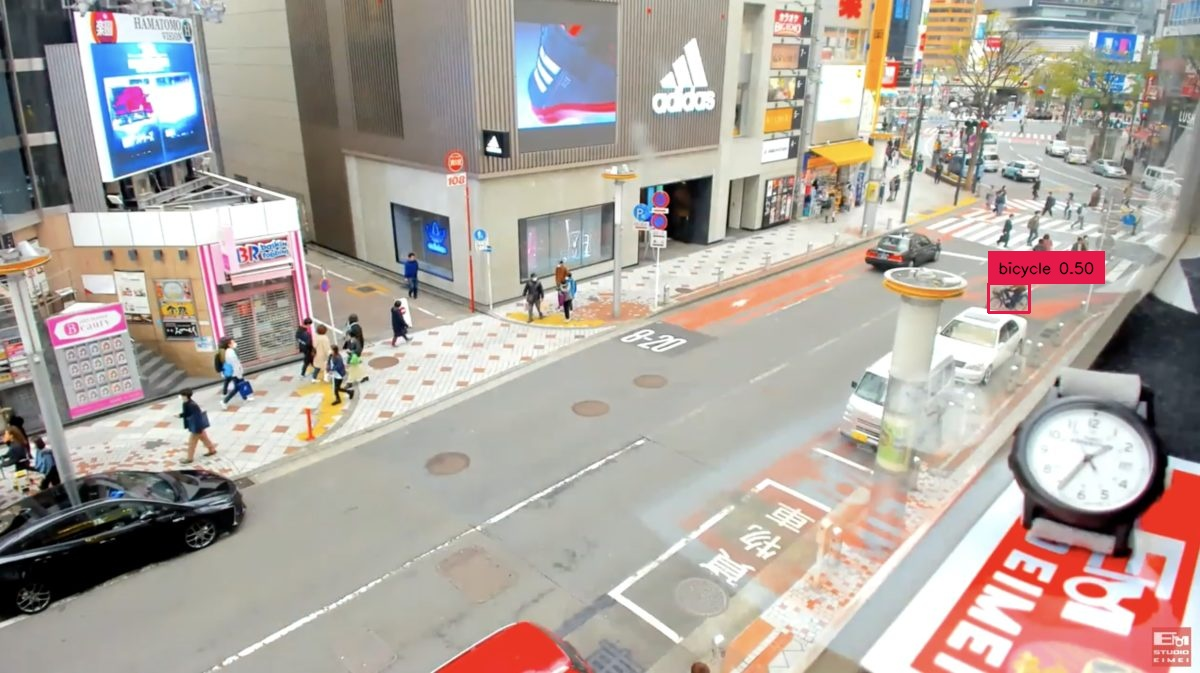

### **3. Human**
パラメータ設定
*   text_prompt="human"

*   box_threshold = 0.21
*   text_threshold = 0.3

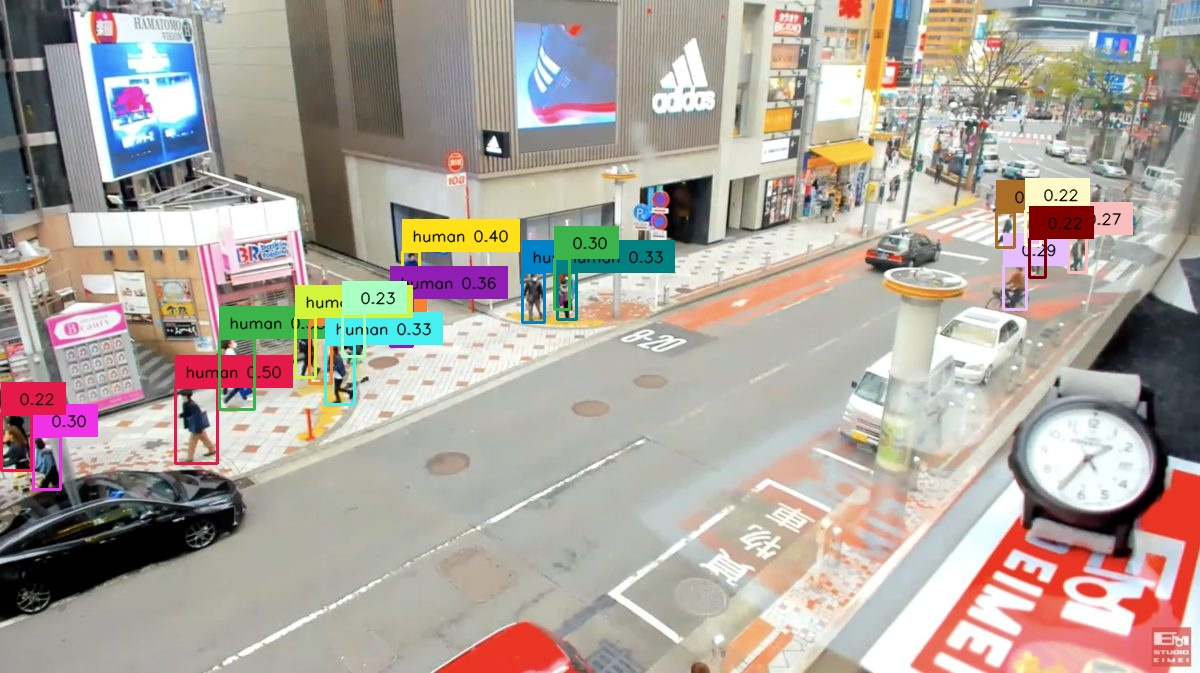

### **4. Car & Bicycle**
パラメータ設定
*   text_prompt="car,bicycle"　※複数クラスの検出も可能です。

*   box_threshold = 0.3
*   text_threshold = 0.3

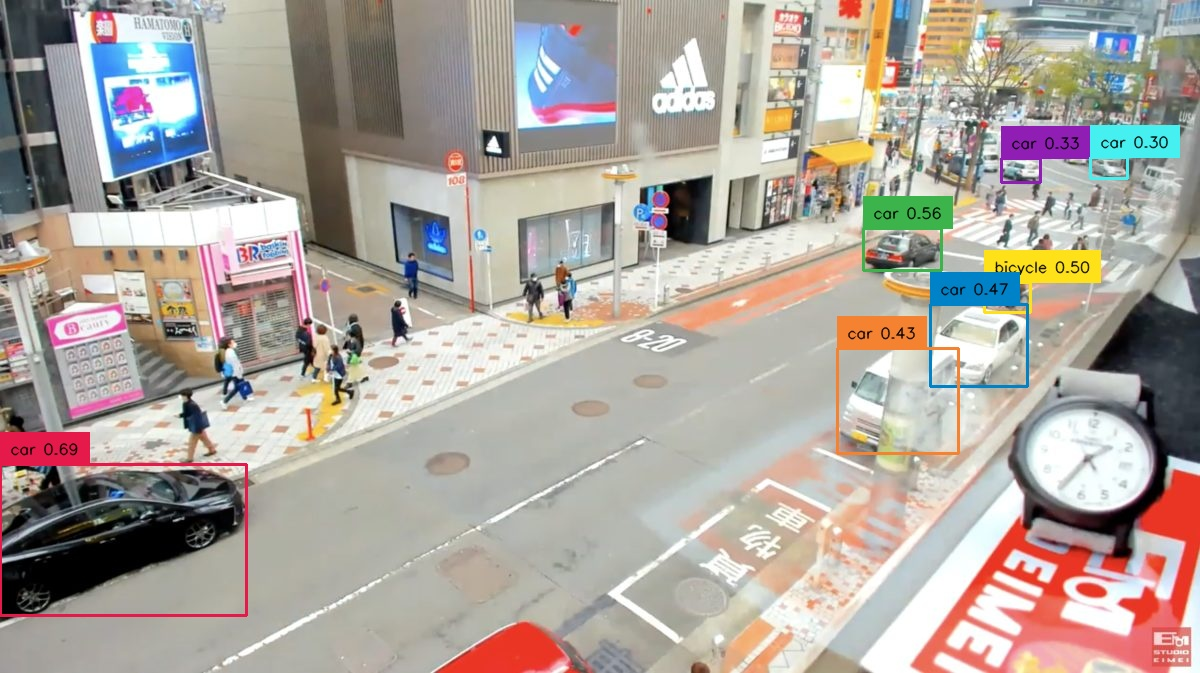